In [36]:
import numpy as np
import pandas as pd
import os
from keras.layers import Dense, Input
from keras.callbacks import EarlyStopping
from keras.models import Model, Sequential
from keras import backend as K
from tqdm import trange
import tensorflow as tf

from dataloader import get_data, get_weather, get_hod, get_dow, get_train_set_qra, get_test_set_qra

months = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

In [2]:
def qloss(y_true, y_pred, q):
    tmp1 = (q / 100 - 1) * (y_true - y_pred)
    tmp2 = q / 100 * (y_true - y_pred)
    return K.mean(K.maximum(tmp1, tmp2))

In [3]:
data_set = 'Irish_2010'
path = os.path.abspath(os.path.join(os.getcwd(), '../..'))

data = get_data(path, data_set)

100%|██████████| 918/918 [00:27<00:00, 32.95it/s]


In [4]:
month = 1
n_clusters = 2
method = 'hierarchical/euclidean'

path_cluster = os.path.join(path, 'result', data_set, 'clustering', 'point', method, f'n_clusters_{n_clusters}.csv')
clusters = pd.read_csv(path_cluster, header=None)

series = data[:, month-1, :months[month-1]*24]
weather = get_weather(path, data_set, month)
week = get_dow(data_set, month)
day = get_hod(month)

In [46]:
for i in range(n_clusters):

    index = list(clusters[month-1] == i)
    sub_series = series[index]
    sub_series = np.sum(sub_series, axis=0)
    
    total_series = np.vstack((sub_series, weather, week, day))
    
    test = total_series[:, -168:]
    train = total_series[:, :-168]
    
    scale = np.zeros(2)
    scale[0] = np.max(train[0])
    scale[1] = np.min(train[0])
    train[0] = (train[0] - scale[1]) / (scale[0] - scale[1])
    test[0] = (test[0] - scale[1]) / (scale[0] - scale[1])
    
    # to get the length of samples
    max_lag = 24
    max_d = 2
    trainX, trainTlag, trainTd, trainY = get_train_set_qra(train, max_lag, max_d)
    l = trainY.shape[0]
    
    num_best = 8
    error_train_step1 = np.zeros((24, 2))
    pred_train = np.zeros((24, 2, l))
    pred_test = np.zeros((24, 2, 168))
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=10)
    for lag in trange(1, 25):
        for d in range(1, 3):
            
            trainX, trainTlag, trainTd, trainY = get_train_set_qra(train, lag, d)
            testX, testTlag, testTd, testY = get_test_set_qra(train, test, lag, d)

            ## QRA step 1
            # linear model
            inputs = Input((5 + lag*3 + d*3,), name='input')
            x = Dense(1, activation=None, use_bias=True, kernel_initializer='he_normal', bias_initializer='he_normal')(inputs)
            model = Model(inputs=inputs, outputs=x)

            # Train
            model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['accuracy'])
            hist1 = model.fit(x=np.hstack((trainX, trainTlag, trainTd)), y=trainY, validation_split=0.2, epochs=1000, verbose=0, callbacks=[early_stopping])

            # Predict (train)
            pred = model.predict(x=np.hstack((trainX, trainTlag, trainTd))[-l:, :])
            error_train_step1[lag-1, d-1] = np.sum(np.abs(pred - trainY[-l:, :]))
            pred_train[lag-1, d-1] = np.squeeze(pred)
            
            # Predict (test)
            pred = model.predict(x=np.hstack((testX, testTlag, testTd)))
            pred_test[lag-1, d-1] = np.squeeze(pred)
    
    # prepare for step 2
    series_train_1 = pred_train[np.argsort(error_train_step1[:,0])[:num_best//2], 0]
    series_train_2 = pred_train[np.argsort(error_train_step1[:,1])[:num_best//2], 1]

    trainX_ = np.vstack((series_train_1, series_train_2)).T
    trainY_ = trainY[-l:, :]
    
    series_test_1 = pred_test[np.argsort(error_train_step1[:,0])[:num_best//2], 0]
    series_test_2 = pred_test[np.argsort(error_train_step1[:,1])[:num_best//2], 1]
    
    testX_ = np.vstack((series_test_1, series_test_2)).T
    testY_ = testY
    
    ## QRA step 2
    # qr model
    total_pred = []
    early_stopping = EarlyStopping(monitor='val_loss', patience=10)
    for q in trange(1, 100):
        
        input_dim = num_best
        model = Sequential([Dense(1, input_shape=(input_dim,))])

        # Train
        model.compile(loss=lambda y_true, y_pred: qloss(y_true, y_pred, q), optimizer='adam')
        hist2 = model.fit(x=trainX_, y=trainY_, validation_split=0.2, epochs=1000, verbose=0, callbacks=[early_stopping])

        # Predict (train)
        pred = model.predict(x=trainX_)
        error_train_step2 = qloss(trainY_, pred, q)

        # Predict (test)
        pred = model.predict(x=testX_)
        error_test_step2 = qloss(testY_, pred, q)
        total_pred.append(np.squeeze(pred))
    
    total_pred = np.array(total_pred)

    break

100%|██████████| 24/24 [02:38<00:00,  6.29s/it]


In [5]:
np.save('train.npy', np.array(error_train))
np.save('test.npy', np.array(error_test))

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

train = np.load('train.npy')
test = np.load('test.npy')

In [2]:
print(np.argsort(train[:,0]))
print(np.argsort(train[:,1]))
print(np.argsort(test[:,0]))
print(np.argsort(test[:,1]))

[16 14 15 20 21  8  6  2  4 13 10 11  1 22  0  7  5  9 18 19  3 12 23 17]
[19 12 14 13 11 21 18  4  6 23  5  7  8  1 20 22 17  0  9 16 10 15  3  2]
[16  7 20 21  8  2 14  6 13 15  1  0  4 10 22 11  9  5 18 19 23  3 12 17]
[ 8 19 12  4 11 14 18  6 21 13  5 23  7  1 20 22 17  0 16 10 15  3  9  2]


In [9]:
test[np.argsort(train[:, 0])[:10], 0]

array([2.69312606, 3.04988148, 3.44675069, 2.79715069, 2.91178251,
       2.97744981, 3.1502586 , 2.97908564, 3.88593404, 3.43215465])

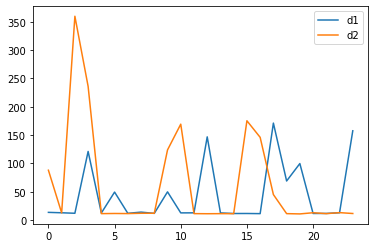

In [3]:
plt.plot(train[:, 0])
plt.plot(train[:, 1])
plt.legend(['d1', 'd2'], loc='upper right')

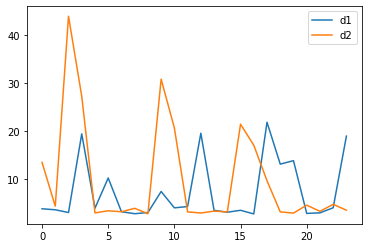

In [4]:
plt.plot(test[:, 0])
plt.plot(test[:, 1])
plt.legend(['d1', 'd2'], loc='upper right')